# Training Notebook — Exam Reference Sheet Generator

**Best to run it here on Google Colab: https://colab.research.google.com/drive/1cARDH59mQB4LZpH5EnlBDk3MEbqb7Cem#scrollTo=Dg93ejlIAHik**

This notebook trains a FLAN-T5 model to generate exam reference sheets from:
- Class notes PDFs
- Exam topics PDFs
- Human-written reference sheets (cheat sheets)

It:
- Builds a train/validation/test split
- Fine-tunes the model with regularization (weight decay + early stopping)
- Logs and visualizes training curves
- Saves the fine-tuned model to `models/cheatsheet_model/`

In [ ]:
!pip install transformers datasets accelerate sentencepiece
!pip install pymupdf reportlab matplotlib pandas

In [ ]:
!pip install -U "transformers" datasets accelerate sentencepiece
!pip install -U pymupdf reportlab matplotlib pandas

In [ ]:
REPO_URL = "https://github.com/arely83/CS372FinalProject.git"
REPO_NAME = "CS372FinalProject"

import os
if not os.path.exists(REPO_NAME):
    !git clone {REPO_URL}
%cd {REPO_NAME}
!git pull

/content/CS372FinalProject
Already up to date.


In [ ]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


In [ ]:
from src.train import train_model, get_training_log_df

train_examples = [
    ("data/train/notes_1.pdf", "data/train/exam_topics_1.pdf", "data/train/cheatsheet_1.pdf"),
    ("data/train/notes_2.pdf", "data/train/exam_topics_2.pdf", "data/train/cheatsheet_2.pdf"),
]

train_examples

[('data/train/notes_1.pdf',
  'data/train/exam_topics_1.pdf',
  'data/train/cheatsheet_1.pdf'),
 ('data/train/notes_2.pdf',
  'data/train/exam_topics_2.pdf',
  'data/train/cheatsheet_2.pdf')]

## Train the Model

This will:
- Load PDFs and build a dataset
- Split into train/validation/test (60/20/20)
- Tokenize inputs and targets
- Configure HuggingFace `Seq2SeqTrainer` with:
  - batching and shuffling
  - weight decay (L2 regularization)
  - early stopping based on validation loss
- Train and save the best model to `models/cheatsheet_model/`

In [ ]:
trainer, tokenized_test = train_model(
    train_examples=train_examples,
    model_name="google/flan-t5-base",
    output_dir="models/cheatsheet_model",
)

print("Training finished. Model saved to models/cheatsheet_model/")

[split_dataset] total examples: 2


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4169: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

/content/CS372FinalProject/src/train.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: arely-sun (arely-sun-duke-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,2.976800,3.875612
2,2.750000,3.846497
3,2.663100,3.823646
4,2.520900,3.805991
5,2.438600,3.794387
6,2.414000,3.790045
7,2.284200,3.785030
8,2.312500,3.779430
9,2.267700,3.774579
10,2.233200,3.770499


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].


Training finished. Model saved to models/cheatsheet_model/


## Evaluate on Test Set

Here we compute basic evaluation metrics on the held-out test split.

In [ ]:
test_metrics = trainer.evaluate(tokenized_test)
test_metrics

{'eval_loss': 3.759939193725586,
 'eval_runtime': 0.4721,
 'eval_samples_per_second': 2.118,
 'eval_steps_per_second': 2.118,
 'epoch': 15.0}

## Visualize Training & Validation Loss

We now visualize the training and validation loss curves over time.

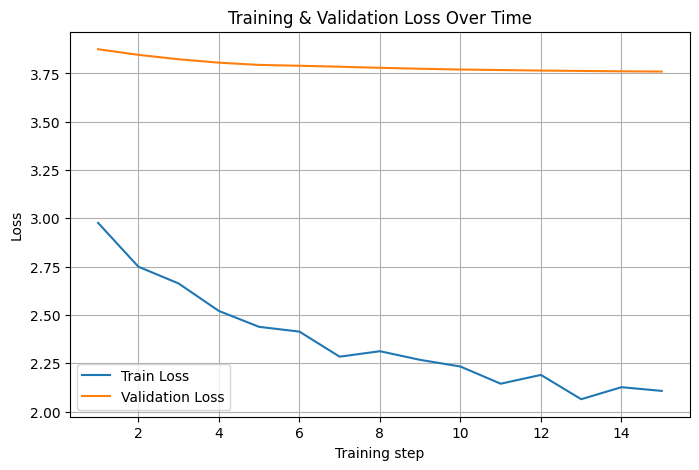

In [ ]:
import matplotlib.pyplot as plt

df_logs = get_training_log_df(trainer)

train_loss = df_logs[df_logs["loss"].notna()][["step", "loss"]]
eval_loss = df_logs[df_logs["eval_loss"].notna()][["step", "eval_loss"]]

plt.figure(figsize=(8, 5))
plt.plot(train_loss["step"], train_loss["loss"], label="Train Loss")
plt.plot(eval_loss["step"], eval_loss["eval_loss"], label="Validation Loss")
plt.xlabel("Training step")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Over Time")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# os.makedirs("docs", exist_ok=True)
# plt.savefig("docs/training_curves.png")
# print("Saved training curves to docs/training_curves.png")

Saved training curves to docs/training_curves.png


<Figure size 640x480 with 0 Axes>

## (Optional) Download Fine-Tuned Model

Run the cell below if you want to download the entire `models/cheatsheet_model/`
directory to your local machine for backup.

In [ ]:

!zip -r cheatsheet_model.zip models/cheatsheet_model

from google.colab import files
files.download("cheatsheet_model.zip")

  adding: models/cheatsheet_model/ (stored 0%)
  adding: models/cheatsheet_model/training_args.bin (deflated 53%)
  adding: models/cheatsheet_model/model.safetensors (deflated 7%)
  adding: models/cheatsheet_model/spiece.model (deflated 48%)
  adding: models/cheatsheet_model/generation_config.json (deflated 27%)
  adding: models/cheatsheet_model/checkpoint-15/ (stored 0%)
  adding: models/cheatsheet_model/checkpoint-15/rng_state.pth (deflated 26%)
  adding: models/cheatsheet_model/checkpoint-15/training_args.bin (deflated 53%)
  adding: models/cheatsheet_model/checkpoint-15/optimizer.pt (deflated 17%)
  adding: models/cheatsheet_model/checkpoint-15/model.safetensors (deflated 7%)
  adding: models/cheatsheet_model/checkpoint-15/spiece.model (deflated 48%)
  adding: models/cheatsheet_model/checkpoint-15/scheduler.pt (deflated 62%)
  adding: models/cheatsheet_model/checkpoint-15/generation_config.json (deflated 27%)
  adding: models/cheatsheet_model/checkpoint-15/trainer_state.json (defla

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>